In [13]:


# Load the dataset files

import numpy as np

# Load dataset files
synthetic_eeg_eog_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/Linear_synthetic_eeg_eog.npy"
clean_eeg_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/EEG_all_epochs.npy"
#linear_synthetic_eeg_eog_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/Linear_synthetic_eeg_eog.npy"
#eeg_all_epochs_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/EEG_all_epochs.npy"
#synthetic_eeg_eog_path = "/home/tulgaa/Desktop/emg_dataset/signal/Linear_synthetic_eeg_emg.npy"
#clean_eeg_path = "/home/tulgaa/Desktop/emg_dataset/signal/EEG_all_epochs.npy"

# Load the numpy arrays
synthetic_eeg_eog = np.load(synthetic_eeg_eog_path, allow_pickle=True).item()  # Dictionary of SNR levels
clean_eeg = np.load(clean_eeg_path)  # Ground truth EEG

# Inspect dataset keys and shapes
print("🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels):", synthetic_eeg_eog.keys())
print("🔹 Clean EEG Shape:", clean_eeg.shape)

# Print shape of each SNR level data
for snr in synthetic_eeg_eog.keys():
    print(f"🔹 SNR Level {snr}: Shape = {synthetic_eeg_eog[snr].shape}")

# Check statistics of clean EEG data
print("🔹 Clean EEG Mean:", np.mean(clean_eeg))
print("🔹 Clean EEG Std Dev:", np.std(clean_eeg))


🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels): dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
🔹 Clean EEG Shape: (3400, 512)
🔹 SNR Level -7: Shape = (3400, 512)
🔹 SNR Level -6: Shape = (3400, 512)
🔹 SNR Level -5: Shape = (3400, 512)
🔹 SNR Level -4: Shape = (3400, 512)
🔹 SNR Level -3: Shape = (3400, 512)
🔹 SNR Level -2: Shape = (3400, 512)
🔹 SNR Level -1: Shape = (3400, 512)
🔹 SNR Level 0: Shape = (3400, 512)
🔹 SNR Level 1: Shape = (3400, 512)
🔹 SNR Level 2: Shape = (3400, 512)
🔹 Clean EEG Mean: -0.16774763156951383
🔹 Clean EEG Std Dev: 231.82429071340553


In [14]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Expand clean EEG dataset (repeat 10 times to match noisy EEG dataset)
X_clean = np.repeat(clean_eeg, 10, axis=0)  # Shape becomes (34,000, 512)

# Step 2: Stack all noisy EEG signals across different SNR levels
X_noisy = np.concatenate([synthetic_eeg_eog[snr] for snr in synthetic_eeg_eog.keys()], axis=0)  # Shape (34,000, 512)

# Step 3: Normalize both clean and noisy EEG signals to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_clean_scaled = scaler.fit_transform(X_clean)  # Normalize clean EEG
X_noisy_scaled = scaler.transform(X_noisy)  # Normalize noisy EEG

# Print dataset details
print(f"✅ Final dataset shapes: Noisy EEG {X_noisy_scaled.shape}, Clean EEG {X_clean_scaled.shape}")
print(f"✅ Clean EEG Mean after Scaling: {np.mean(X_clean_scaled):.4f}, Std Dev: {np.std(X_clean_scaled):.4f}")
print(f"✅ Noisy EEG Mean after Scaling: {np.mean(X_noisy_scaled):.4f}, Std Dev: {np.std(X_noisy_scaled):.4f}")


✅ Final dataset shapes: Noisy EEG (34000, 512), Clean EEG (34000, 512)
✅ Clean EEG Mean after Scaling: -0.0066, Std Dev: 0.2461
✅ Noisy EEG Mean after Scaling: -0.0070, Std Dev: 0.6368


In [15]:
from sklearn.model_selection import train_test_split

# Initialize lists to store train/test sets
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Split each SNR level separately to preserve SNR distribution
for snr in synthetic_eeg_eog.keys():
    noisy_snr = synthetic_eeg_eog[snr]  # Get noisy EEG data for this SNR level
    clean_snr = clean_eeg  # Corresponding clean EEG data

    # Split into 80% Train, 20% Test
    X_train_snr, X_test_snr, y_train_snr, y_test_snr = train_test_split(
        noisy_snr, clean_snr, test_size=0.2, random_state=42
    )

    # Store the results
    X_train_list.append(X_train_snr)
    X_test_list.append(X_test_snr)
    y_train_list.append(y_train_snr)
    y_test_list.append(y_test_snr)

# Stack all train and test data together
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.vstack(y_train_list)
y_test = np.vstack(y_test_list)

# Print dataset sizes
print(f"✅ Final Train Set: Noisy EEG {X_train.shape}, Clean EEG {y_train.shape}")
print(f"✅ Final Test Set: Noisy EEG {X_test.shape}, Clean EEG {y_test.shape}")


✅ Final Train Set: Noisy EEG (27200, 512), Clean EEG (27200, 512)
✅ Final Test Set: Noisy EEG (6800, 512), Clean EEG (6800, 512)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the EEGDiR LSTM Model
class EEGDiR_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=512, num_layers=2, dropout=0.3):
        super(EEGDiR_LSTM, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(hidden_size, 64)  
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, input_size)  

        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output the denoised EEG
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGDiR_LSTM().to(device)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(f"✅ Model is initialized on {device}")


✅ Model is initialized on cuda


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom PyTorch Dataset
class EEGDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = torch.tensor(noisy_data, dtype=torch.float32).unsqueeze(-1)  # (N, 512, 1)
        self.clean_data = torch.tensor(clean_data, dtype=torch.float32).unsqueeze(-1)  # (N, 512, 1)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.clean_data[idx]

# Define batch size
batch_size = 512

# Create DataLoader for training and testing
train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoaders are ready! Training Batch Size: {batch_size}")


✅ DataLoaders are ready! Training Batch Size: 512


In [18]:
import torch.optim.lr_scheduler as lr_scheduler

# Function to train the model with Early Stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=3):
    model.train()  # Set model to training mode

    best_loss = float("inf")
    early_stop_counter = 0

    # Learning Rate Scheduler (Reduce LR if loss plateaus)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_test_loss = 0.0

        # Training loop
        for noisy_batch, clean_batch in train_loader:
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)

            optimizer.zero_grad()
            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for noisy_batch, clean_batch in test_loader:
                noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
                outputs = model(noisy_batch)
                loss = criterion(outputs, clean_batch)
                total_test_loss += loss.item()

        model.train()

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(test_loader)

        # Learning rate scheduling
        scheduler.step(avg_test_loss)

        # Print loss for monitoring
        print(f"🔹 Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

        # Check for early stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            early_stop_counter = 0  # Reset counter
            torch.save(model.state_dict(), "best_lstm_model.pth")  # Save best model
            print("✅ Model Improved! Saving...")
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("⏹️ Early Stopping Triggered. Training Stopped!")
            break

    print("✅ Training Completed!")

# Start Training with Early Stopping
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=3)


/home/tulgaa/anaconda3/envs/medsam/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


🔹 Epoch [1/50] | Train Loss: 51470.862703 | Test Loss: 46119.135603
✅ Model Improved! Saving...
🔹 Epoch [2/50] | Train Loss: 36898.140589 | Test Loss: 27478.539342
✅ Model Improved! Saving...
🔹 Epoch [3/50] | Train Loss: 25417.932907 | Test Loss: 22053.323451
✅ Model Improved! Saving...
🔹 Epoch [4/50] | Train Loss: 22723.059679 | Test Loss: 21330.646345
✅ Model Improved! Saving...
🔹 Epoch [5/50] | Train Loss: 21370.263166 | Test Loss: 20933.506278
✅ Model Improved! Saving...
🔹 Epoch [6/50] | Train Loss: 20617.487232 | Test Loss: 19498.939383
✅ Model Improved! Saving...
🔹 Epoch [7/50] | Train Loss: 19935.764793 | Test Loss: 19220.905413
✅ Model Improved! Saving...
🔹 Epoch [8/50] | Train Loss: 19479.623300 | Test Loss: 19078.837751
✅ Model Improved! Saving...
🔹 Epoch [9/50] | Train Loss: 19085.991970 | Test Loss: 18717.351911
✅ Model Improved! Saving...
🔹 Epoch [10/50] | Train Loss: 18872.106301 | Test Loss: 19001.520159
🔹 Epoch [11/50] | Train Loss: 18493.373119 | Test Loss: 18297.12772

In [19]:
import numpy as np
from scipy.stats import pearsonr
from scipy.fftpack import fft

# Load the best trained model
model.load_state_dict(torch.load("best_lstm_model.pth"))
model.eval()

# Function to compute RRMSE (Relative Root Mean Square Error)
def compute_rrmse(denoised, clean):
    return np.sqrt(np.mean((denoised - clean) ** 2)) / np.sqrt(np.mean(clean ** 2))

# Function to compute RRMSE in the Spectrum Domain (RRMSE-S)
def compute_rrmse_spectrum(denoised, clean):
    fft_clean = np.abs(fft(clean))  # Compute FFT
    fft_denoised = np.abs(fft(denoised))
    return compute_rrmse(fft_denoised, fft_clean)

# Function to compute Correlation Coefficient (CC)
def compute_cc(denoised, clean):
    return pearsonr(denoised.flatten(), clean.flatten())[0]

# Store results per SNR level
snr_metrics = {}

# Lists to store all values for overall averages
all_rrmse_t = []
all_rrmse_s = []
all_cc = []

# Loop through each SNR level and use pre-split test data
with torch.no_grad():
    for snr_idx, snr in enumerate(synthetic_eeg_eog.keys()):
        print(f"🔹 Evaluating for SNR Level: {snr}")

        # Get the pre-split test data from training
        noisy_snr = X_test_list[snr_idx]  # Use the pre-stored X_test
        clean_snr = y_test_list[snr_idx]  # Use the pre-stored y_test

        # Convert to PyTorch tensors
        noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(-1).to(device)
        clean_tensor = torch.tensor(clean_snr, dtype=torch.float32).unsqueeze(-1).to(device)

        # Get model predictions
        denoised_tensor = model(noisy_tensor).cpu().numpy().squeeze()
        clean_snr_np = clean_tensor.cpu().numpy().squeeze()

        # Compute metrics
        rrmse_t_list = [compute_rrmse(denoised_tensor[i], clean_snr_np[i]) for i in range(len(clean_snr_np))]
        rrmse_s_list = [compute_rrmse_spectrum(denoised_tensor[i], clean_snr_np[i]) for i in range(len(clean_snr_np))]
        cc_list = [compute_cc(denoised_tensor[i], clean_snr_np[i]) for i in range(len(clean_snr_np))]

        # Store results for this SNR level
        snr_metrics[snr] = {
            "RRMSE-T": np.mean(rrmse_t_list),
            "RRMSE-S": np.mean(rrmse_s_list),
            "CC": np.mean(cc_list)
        }

        # Append values for overall averaging
        all_rrmse_t.extend(rrmse_t_list)
        all_rrmse_s.extend(rrmse_s_list)
        all_cc.extend(cc_list)

# Compute overall averages
overall_rrmse_t = np.mean(all_rrmse_t)
overall_rrmse_s = np.mean(all_rrmse_s)
overall_cc = np.mean(all_cc)

# Print Results in Table Format
print("\n🔹 **Final Evaluation Per SNR Level:**")
print("-----------------------------------------------------")
print("| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |")
print("-----------------------------------------------------")
for snr in sorted(snr_metrics.keys()):
    print(f"| {snr:3d}  |  {snr_metrics[snr]['RRMSE-T']:.6f}  |  {snr_metrics[snr]['RRMSE-S']:.6f}  |  {snr_metrics[snr]['CC']:.6f}  |")
print("-----------------------------------------------------")

# Print Overall Averages
print("\n🔹 **Overall Averages**:")
print(f"✅ RRMSE-T: {overall_rrmse_t:.6f}, RRMSE-S: {overall_rrmse_s:.6f}, CC: {overall_cc:.6f}")


🔹 Evaluating for SNR Level: -7
🔹 Evaluating for SNR Level: -6
🔹 Evaluating for SNR Level: -5
🔹 Evaluating for SNR Level: -4
🔹 Evaluating for SNR Level: -3
🔹 Evaluating for SNR Level: -2
🔹 Evaluating for SNR Level: -1
🔹 Evaluating for SNR Level: 0
🔹 Evaluating for SNR Level: 1
🔹 Evaluating for SNR Level: 2

🔹 **Final Evaluation Per SNR Level:**
-----------------------------------------------------
| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |
-----------------------------------------------------
|  -7  |  0.719608  |  0.456432  |  0.705716  |
|  -6  |  0.672730  |  0.430752  |  0.742743  |
|  -5  |  0.635776  |  0.409007  |  0.771013  |
|  -4  |  0.603623  |  0.390027  |  0.794579  |
|  -3  |  0.573043  |  0.370970  |  0.816031  |
|  -2  |  0.543463  |  0.354163  |  0.835532  |
|  -1  |  0.511421  |  0.335403  |  0.855572  |
|   0  |  0.481013  |  0.317967  |  0.873721  |
|   1  |  0.452641  |  0.302376  |  0.889855  |
|   2  |  0.426698  |  0.289108  |  0.903905  |
------------------------

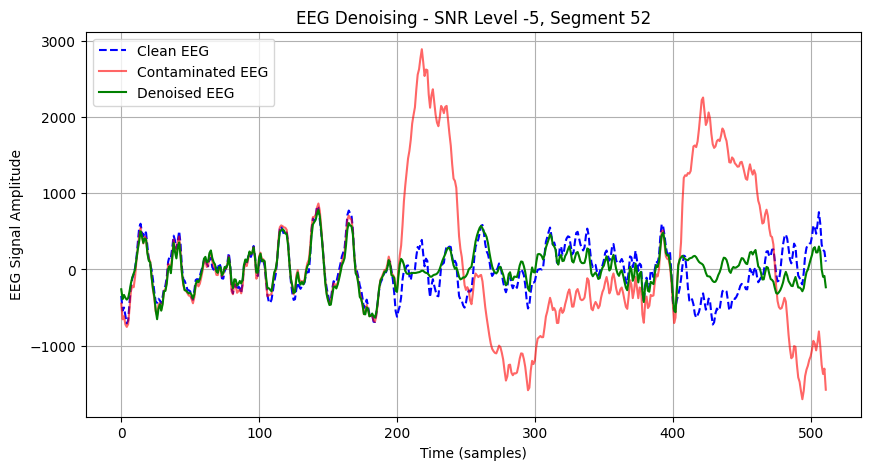

In [74]:
import matplotlib.pyplot as plt

# Select SNR level 1
snr_level = -5
snr_idx = list(synthetic_eeg_eog.keys()).index(snr_level)  # Get index of SNR=1 in test list

# Get test data for SNR=1
noisy_snr = X_test_list[snr_idx]  # Noisy (contaminated) EEG from test set
clean_snr = y_test_list[snr_idx]  # Clean EEG from test set

# Convert to PyTorch tensor and denoise
noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(-1).to(device)
denoised_tensor = model(noisy_tensor).cpu().detach().numpy().squeeze()

# Select the 0th segment (first sample)
segment_idx = 52
noisy_segment = noisy_snr[segment_idx]
clean_segment = clean_snr[segment_idx]
denoised_segment = denoised_tensor[segment_idx]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
plt.plot(denoised_segment, label="Denoised EEG", color="green", linewidth=1.5)

plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Amplitude")
plt.title(f"EEG Denoising - SNR Level {snr_level}, Segment {segment_idx}")
plt.legend()
plt.grid(True)
plt.show()


In [82]:
# Print Denoised EEG Points for the Selected Segment
print("🟢 Denoised EEG Plotting Points:")
for i, value in enumerate(denoised_segment):
    print(f"({i}, {value})")


🟢 Denoised EEG Plotting Points:
(0, -259.9222717285156)
(1, -389.66778564453125)
(2, -334.3177490234375)
(3, -372.08392333984375)
(4, -396.25921630859375)
(5, -374.33135986328125)
(6, -288.0901184082031)
(7, -182.47488403320312)
(8, -103.72859191894531)
(9, -54.827476501464844)
(10, 3.3894548416137695)
(11, 134.28028869628906)
(12, 261.44854736328125)
(13, 371.3244934082031)
(14, 501.216796875)
(15, 440.75128173828125)
(16, 348.58734130859375)
(17, 407.5715026855469)
(18, 393.048095703125)
(19, 206.22779846191406)
(20, 114.203369140625)
(21, 93.45211029052734)
(22, -101.84244537353516)
(23, -248.8566131591797)
(24, -352.294921875)
(25, -535.7508544921875)
(26, -653.122314453125)
(27, -516.3311767578125)
(28, -457.42767333984375)
(29, -540.863037109375)
(30, -457.4198913574219)
(31, -287.9681091308594)
(32, -281.34112548828125)
(33, -188.0176239013672)
(34, 2.913835048675537)
(35, 42.92910385131836)
(36, -48.4781494140625)
(37, 157.9099578857422)
(38, 348.0324401855469)
(39, 227.3733825

: 

In [81]:
print("🟢 Clean EEG Plotting Points:")
for i, value in enumerate(clean_segment):
    print(f"({i}, {value})")

🟢 Clean EEG Plotting Points:
(0, -346.3016269609484)
(1, -539.670147376018)
(2, -500.09262938088096)
(3, -607.6149419072029)
(4, -709.7435641455005)
(5, -670.0262559312787)
(6, -434.27996174170437)
(7, -219.20121339965132)
(8, -117.11538295861604)
(9, -65.63973742579792)
(10, 18.949376273159594)
(11, 150.48240901293522)
(12, 346.0815881691253)
(13, 550.4028440459957)
(14, 600.7830697744357)
(15, 488.8480417554207)
(16, 436.3814413724026)
(17, 504.9149366462159)
(18, 481.4728655281674)
(19, 297.6004953182689)
(20, 134.8211778956924)
(21, 67.56969266978217)
(22, -3.610482759472019)
(23, -133.1717582802037)
(24, -297.72892585168324)
(25, -428.0041597139429)
(26, -438.02785661723436)
(27, -384.4447784709387)
(28, -407.65924652526274)
(29, -444.51847908893274)
(30, -358.5204863860559)
(31, -250.70758246187694)
(32, -215.00272707828384)
(33, -102.37535313080305)
(34, 100.58648024383318)
(35, 174.01358219048646)
(36, 157.11372111312934)
(37, 286.21185360554915)
(38, 444.0218459494931)
(39, 37

In [75]:
# Convert string labels like 'SNR_-5' to integers
snr_labels_test_int = np.array([int(str(s).replace("SNR_", "")) for s in snr_labels_test])

# Target SNR level
snr_level = -5

# Find indices of test samples with SNR -5
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

# Nicely print them
print(f"SNR Level {snr_level} indices in test set:", snr_indices.tolist())


NameError: name 'snr_labels_test' is not defined

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np

# Initialize lists
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []
snr_labels_test = []

snr_keys = sorted(synthetic_eeg_eog.keys())  # Keep consistent order
samples_per_snr = clean_eeg.shape[0]         # e.g., 4514

for i, snr in enumerate(snr_keys):
    noisy_snr = synthetic_eeg_eog[snr]
    start_idx = i * samples_per_snr
    end_idx = (i + 1) * samples_per_snr
    clean_snr = X_clean[start_idx:end_idx]  # ✅ Extract correct slice

    # Split
    X_train_snr, X_test_snr, y_train_snr, y_test_snr = train_test_split(
        noisy_snr, clean_snr, test_size=0.2, random_state=42
    )

    # Append
    X_train_list.append(X_train_snr)
    X_test_list.append(X_test_snr)
    y_train_list.append(y_train_snr)
    y_test_list.append(y_test_snr)
    snr_labels_test.extend([snr] * len(X_test_snr))

# Stack
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.vstack(y_train_list)
y_test = np.vstack(y_test_list)
snr_labels_test = np.array(snr_labels_test)

# Global shuffle ✅
X_test, y_test, snr_labels_test = shuffle(X_test, y_test, snr_labels_test, random_state=42)

# Print shape info
print(f"✅ Final Train Set: {X_train.shape}, Clean: {y_train.shape}")
print(f"✅ Final Test Set: {X_test.shape}, Clean: {y_test.shape}")


✅ Final Train Set: (27200, 512), Clean: (27200, 512)
✅ Final Test Set: (6800, 512), Clean: (6800, 512)


In [79]:
# Convert 'SNR_-5' to integer -5, etc.
snr_labels_test_int = np.array([int(str(s).replace("SNR_", "")) for s in snr_labels_test])

# Find test indices for SNR -5
snr_level = -5
snr_indices = np.where(snr_labels_test_int == snr_level)[0]
print(f"SNR Level {snr_level} indices in test set:", snr_indices.tolist())


SNR Level -5 indices in test set: [17, 22, 27, 43, 54, 66, 77, 94, 99, 116, 124, 137, 157, 180, 181, 182, 200, 209, 214, 221, 236, 238, 242, 244, 248, 256, 257, 262, 264, 265, 268, 270, 282, 307, 350, 365, 370, 389, 391, 393, 418, 424, 426, 430, 433, 440, 442, 443, 447, 449, 456, 471, 495, 509, 515, 516, 521, 526, 535, 540, 541, 542, 543, 545, 547, 566, 568, 593, 596, 628, 631, 640, 641, 648, 654, 690, 693, 704, 715, 720, 722, 733, 736, 737, 752, 756, 758, 762, 769, 777, 788, 789, 795, 806, 811, 827, 830, 848, 863, 864, 867, 870, 872, 891, 903, 914, 915, 945, 959, 981, 982, 1006, 1017, 1031, 1043, 1055, 1080, 1091, 1111, 1113, 1114, 1129, 1147, 1157, 1168, 1170, 1171, 1200, 1207, 1217, 1232, 1236, 1244, 1282, 1287, 1300, 1315, 1328, 1332, 1337, 1346, 1355, 1371, 1381, 1396, 1410, 1423, 1434, 1450, 1467, 1474, 1482, 1485, 1504, 1513, 1529, 1530, 1531, 1536, 1550, 1553, 1572, 1578, 1581, 1582, 1586, 1589, 1592, 1626, 1627, 1646, 1657, 1664, 1693, 1702, 1733, 1741, 1753, 1756, 1759, 1762,

In [80]:
print("🟢 Clean EEG Plotting Points:")
for i, value in enumerate(noisy_segment):
    print(f"({i}, {value})")

🟢 Clean EEG Plotting Points:
(0, -448.8458768019658)
(1, -654.543935775602)
(2, -614.8835477189386)
(3, -722.765245324984)
(4, -754.285318032791)
(5, -717.6342797130103)
(6, -515.7103513645092)
(7, -287.99406634820537)
(8, -215.5144856211686)
(9, -233.87274599471613)
(10, -102.54232300108214)
(11, 111.10067466599239)
(12, 274.1560028047621)
(13, 450.2978859251799)
(14, 547.2637188055763)
(15, 429.1136893642165)
(16, 341.0567846842803)
(17, 431.17953704300544)
(18, 408.7151558745388)
(19, 224.15223408502735)
(20, 147.80800322973727)
(21, 102.32575577861424)
(22, -91.3570650377659)
(23, -269.53717462468376)
(24, -383.9359504980613)
(25, -553.8088080235315)
(26, -603.9047272061944)
(27, -462.13388937454357)
(28, -441.8691720680838)
(29, -532.9849522282971)
(30, -429.72645358804806)
(31, -275.4217293113488)
(32, -268.6614959854083)
(33, -155.18333500789296)
(34, 70.02357456598806)
(35, 62.80754468577926)
(36, -11.159055181857582)
(37, 196.54294802493658)
(38, 392.0567914059477)
(39, 279.30